# Net Radiation

In [1]:
import os
import numpy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
SITE_FOLDER = '/disk2/workspace/20240323/EC_site_obs'
DATA_FOLDER = '/disk2/workspace/20240323/processing_record'
storage_folder = '/disk2/workspace/20240323'

In [3]:
def read_site_csv(csv_filename):
    csv_data = numpy.genfromtxt(csv_filename, delimiter=',', dtype=str)
    csv_v = csv_data[:, 1]
    csv_v = csv_v.astype(float)
    return csv_data[:, 0], csv_v[:]


def read_site_csv_30minto10min(csv_filename):
    csv_data = numpy.genfromtxt(csv_filename, delimiter=',', dtype=str)
    csv_v = csv_data[:, 1]
    csv_v[csv_v=='']='nan'
    csv_v = csv_v.astype(float)
    
    new_len = 3 * len(csv_v)
    arr_10min = numpy.full(new_len, numpy.nan)
    arr_10min[::3] = csv_v
    
    return arr_10min


def mapping_comparison_single(site_obs, site_cal, fig_title='', axis_min=-200, axis_max=900):
    plt.figure(figsize=(8,8))
    
    nan_indices = numpy.isnan(site_obs) | numpy.isnan(site_cal)

    # 删除包含 NaN 值的位置
    x = site_obs[~nan_indices]
    y = site_cal[~nan_indices]
    
    # 绘制1:1参考线
    x_11 = numpy.arange(axis_min, axis_max + 1)
    y_11 = 1 * x_11
    plt.plot(x_11, y_11, color='k', linewidth=1, linestyle='--',)

    # 使用线性回归模型拟合数据
    model = LinearRegression()
    x = x.reshape(-1, 1)
    model.fit(x, y)
    y_pred = model.predict(x)
    xx = numpy.arange(axis_min, axis_max + 0.1, 0.05)
    yy_pred = model.coef_[0] * xx + model.intercept_
    
    # 绘制密度散点图
    xy = numpy.vstack([x.flatten(), y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x_, y_, z = x[idx], y[idx], z[idx]
    z = (z-numpy.min(z))/(numpy.max(z)-numpy.min(z))*100
    plt.scatter(x_, y_, marker='o', c=z, s=8, cmap='turbo')
    
    # 绘制散点图和回归线
#     plt.scatter(x, y, color='b')
    plt.plot(xx, yy_pred, color='red')
    

    # 添加标签
    plt.title(fig_title)
    plt.xlabel('Net radiation observed at site (W/m²)')
    plt.ylabel('Net radiation calculated for ET (W/m²)')
    
    # 计算散点个数
    num = numpy.count_nonzero(~numpy.isnan(x))

    # 计算回归方程
    equation = f'y = {model.coef_[0]:.2f} * x + {model.intercept_:.2f}'

    # 计算评估指标
    r2 = r2_score(y, y_pred)
    rmse = numpy.sqrt(mean_squared_error(y, y_pred))
    bias = numpy.mean(y_pred - y)
    mae = mean_absolute_error(y, y_pred)

    print('N:', num)
    print('R²:', r2)
    print('RMSE:', rmse)
    print('Bias:', bias)
    print('MAE', mae)

    plt.annotate(f'N: {num:d}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)
    plt.annotate(equation, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'R²: {r2:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.80), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'Bias: {bias:.2f}', xy=(0.05, 0.75), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'MAE: {mae:.2f}', xy=(0.05, 0.70), xycoords='axes fraction', fontsize=10)

    # 显示图形
    plt.xlim((axis_min, axis_max))
    plt.ylim((axis_min, axis_max))
#     plt.colorbar(label='density')
    plt.show()
    plt.clf()

    
def show_r_net_curve_week(site_name, obs_timelist, week_idx, site_obs, site_cal, save_flag=0):
    # 30-min
    # good 30
    #     week_idx = 30

    week_obs_10min = site_obs[7*24*6*week_idx:7*24*6*(week_idx+1)]
    week_obs_hh = week_obs_10min[::3]

    week_cal_10min = site_cal[7*24*6*week_idx:7*24*6*(week_idx+1)]
    week_cal_hh = week_cal_10min[::3]

    week_timelist_10min = obs_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
    # week_timelist_hh = week_timelist_10min[::3]

    formatted_dates = []
    for date_string in week_timelist_10min:
        dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
        formatted_date = dt_object.strftime("%-H:%M")
        formatted_dates.append(formatted_date)

    plt.figure(figsize=(18, 4))
    plt.plot(numpy.linspace(0, len(week_obs_hh), len(week_obs_hh)), week_obs_hh, '-', color='black', label='EC-site observed net radiation')
    plt.plot(numpy.linspace(0, len(week_cal_hh), len(week_cal_hh)), week_cal_hh, '-', color='red', label='Input net radiation for ET estimation')
    plt.plot(numpy.linspace(0, len(week_cal_hh), len(week_cal_hh)), week_cal_hh, '.', color='red')
    plt.xticks(numpy.linspace(0, len(week_obs_hh), int(len(week_obs_hh)/6)), formatted_dates[::18], rotation=45, ha='right')
    plt.ylabel(r'$W/m^2$', fontsize=14)
    plt.xlim(0,len(week_obs_hh))
    plt.ylim((-100,950))
    title_str = site_name + ' ' + (week_timelist_10min[0] + ' - ' + week_timelist_10min[-1]).replace('T',' ').replace('Z','')
    plt.title(title_str)
    plt.legend()
    if save_flag:
        plt.savefig(storage_folder + '/Rnet ' + title_str + '.png', dpi=300)
    else:
        plt.show()
        plt.clf()

## Site Obs

In [4]:
site_names = ['JRC', 'BBY', 'TKY', 'CRK', 'GCK', 'GDK', 'SIP', 'SDP']

N: 11065
R²: 0.9084957469395297
RMSE: 73.36234712654645
Bias: -1.1507388906300042e-14
MAE 47.38214260503333


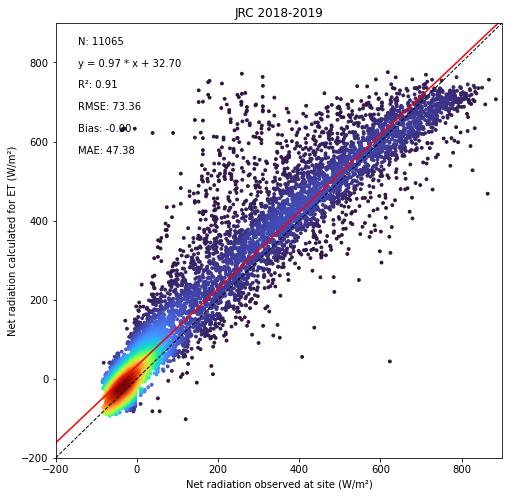

<Figure size 432x288 with 0 Axes>

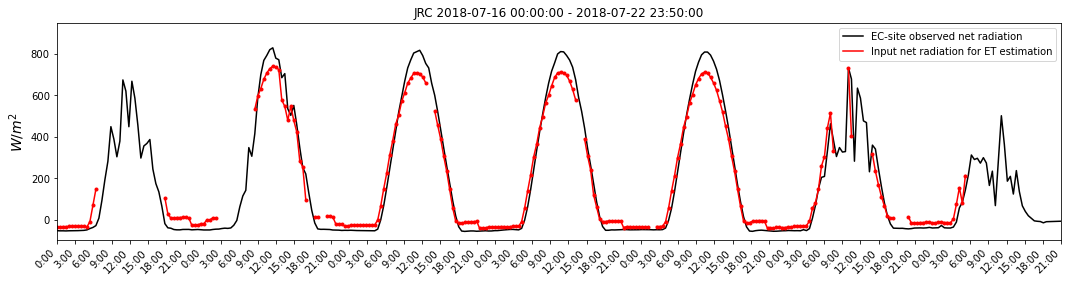

<Figure size 432x288 with 0 Axes>

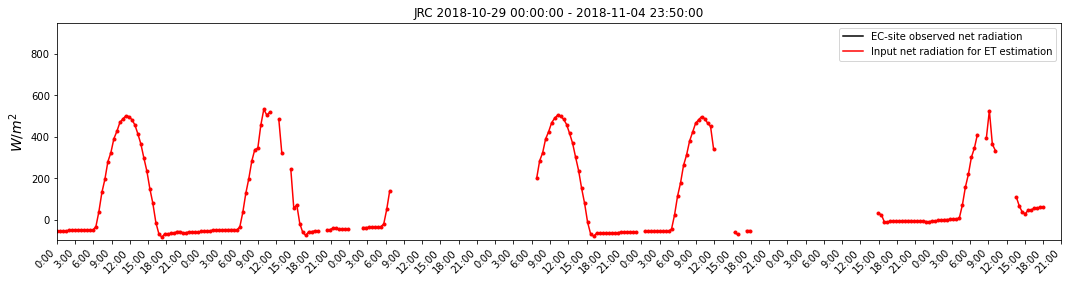

N: 5770
R²: 0.9137085078814917
RMSE: 63.21567007554498
Bias: -1.7023471021053075e-14
MAE 42.82794056959335


<Figure size 432x288 with 0 Axes>

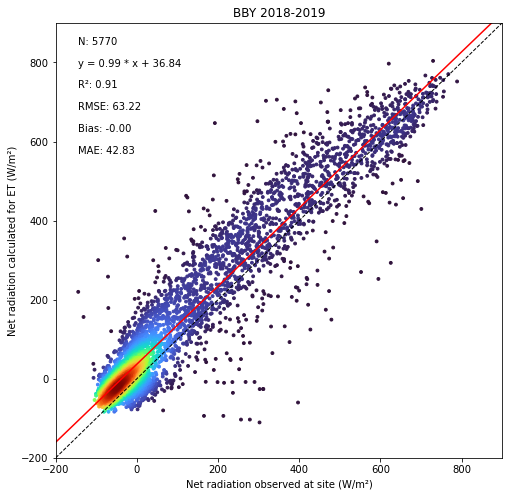

<Figure size 432x288 with 0 Axes>

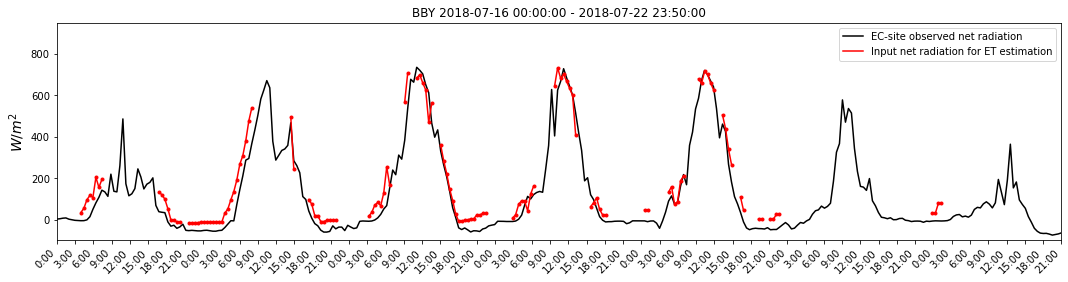

<Figure size 432x288 with 0 Axes>

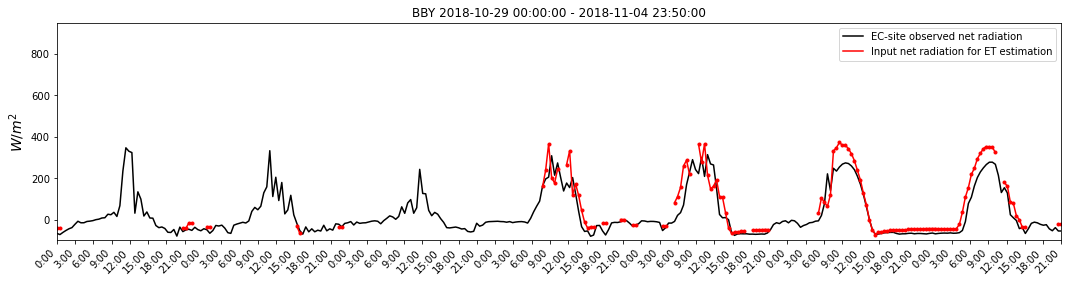

N: 7228
R²: 0.8995696577873705
RMSE: 76.49486930267409
Bias: 1.1072984747650481e-14
MAE 47.658664717802544


<Figure size 432x288 with 0 Axes>

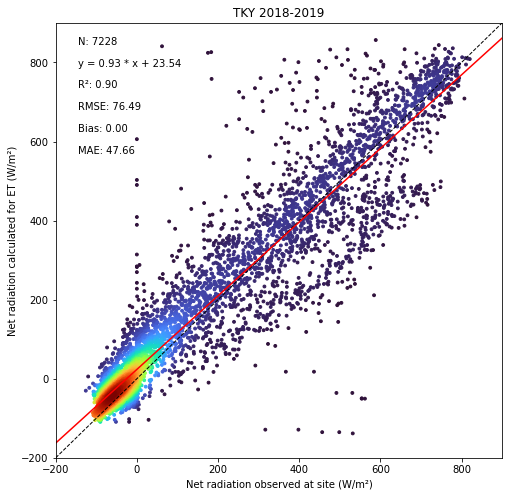

<Figure size 432x288 with 0 Axes>

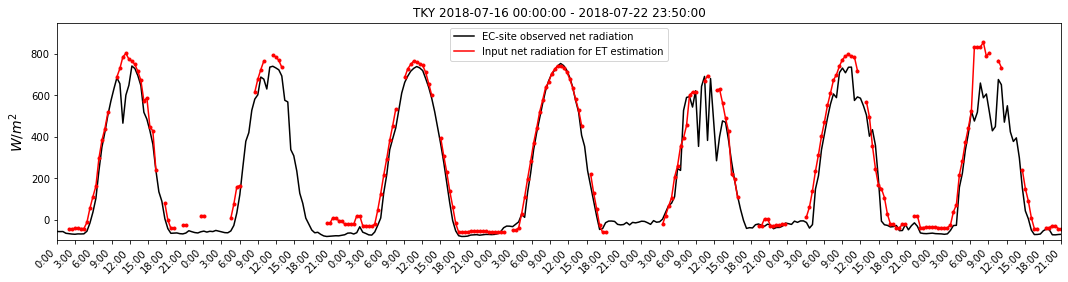

<Figure size 432x288 with 0 Axes>

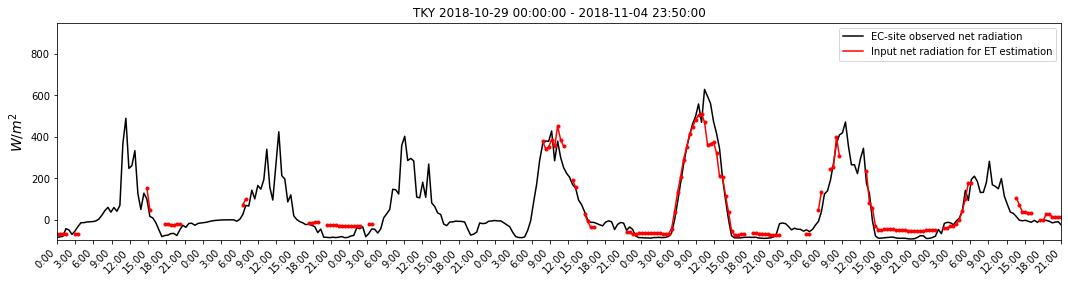

N: 19225
R²: 0.944011343868432
RMSE: 54.80294352410789
Bias: -5.747911899371172e-15
MAE 35.90774636972203


<Figure size 432x288 with 0 Axes>

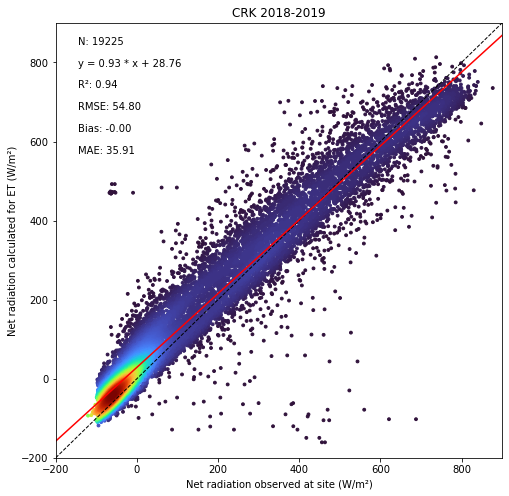

<Figure size 432x288 with 0 Axes>

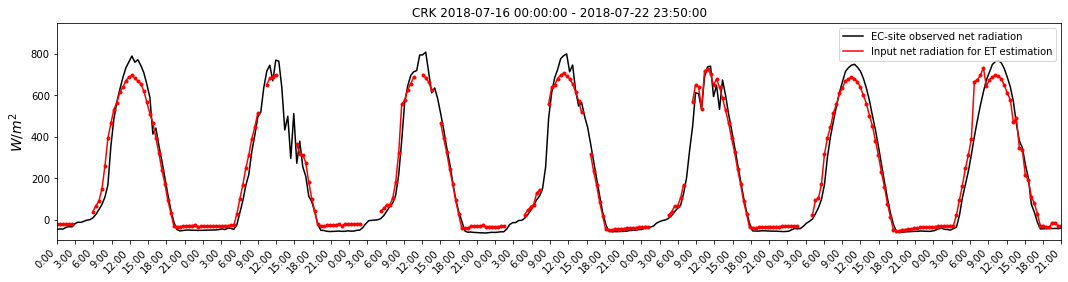

<Figure size 432x288 with 0 Axes>

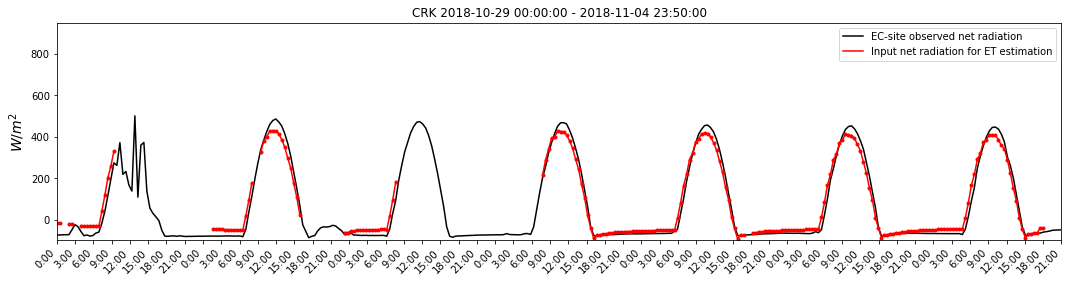

N: 18932
R²: 0.9450856686066429
RMSE: 54.83891593630764
Bias: 6.91777081424581e-15
MAE 35.51239973401474


<Figure size 432x288 with 0 Axes>

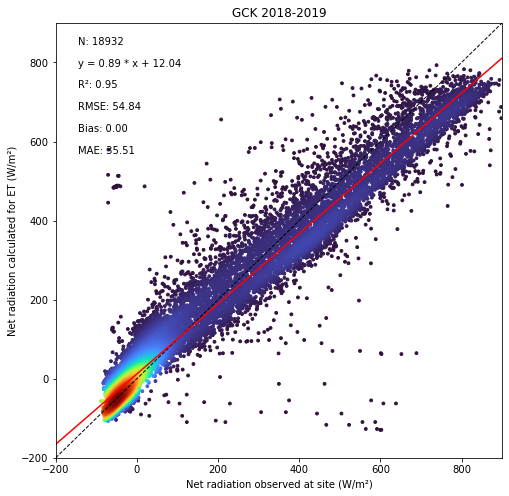

<Figure size 432x288 with 0 Axes>

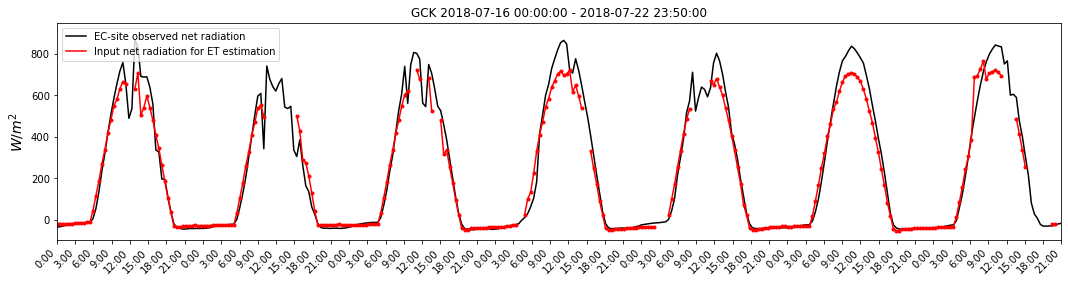

<Figure size 432x288 with 0 Axes>

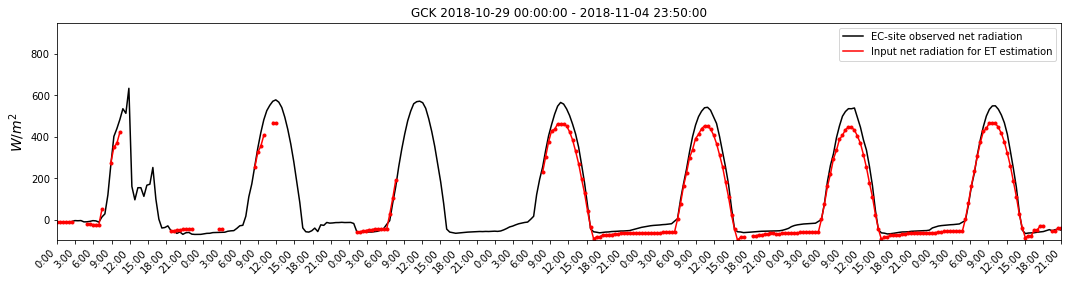

N: 18798
R²: 0.9393921698138081
RMSE: 57.7424068043668
Bias: -5.999433079042616e-15
MAE 37.468539393994796


<Figure size 432x288 with 0 Axes>

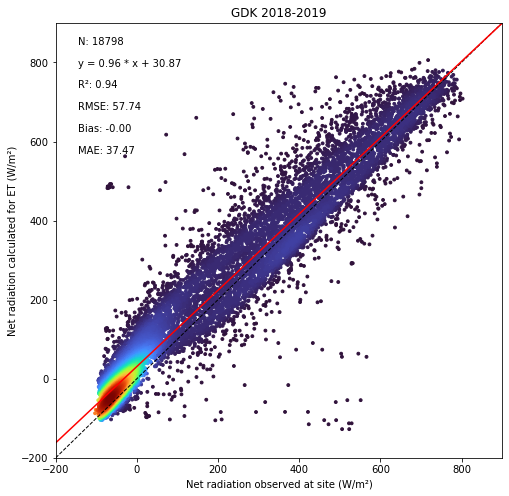

<Figure size 432x288 with 0 Axes>

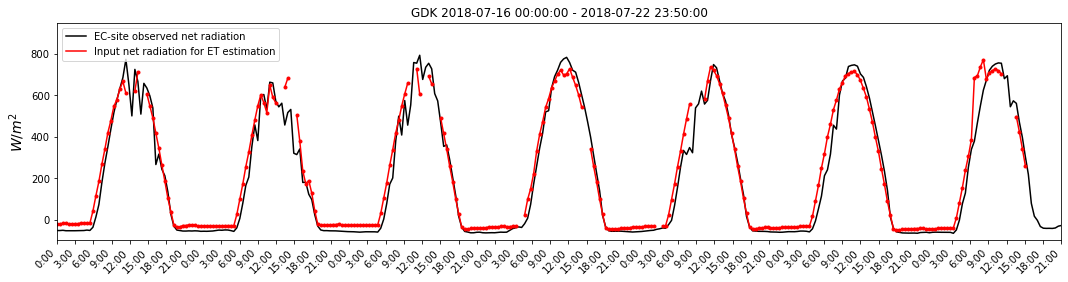

<Figure size 432x288 with 0 Axes>

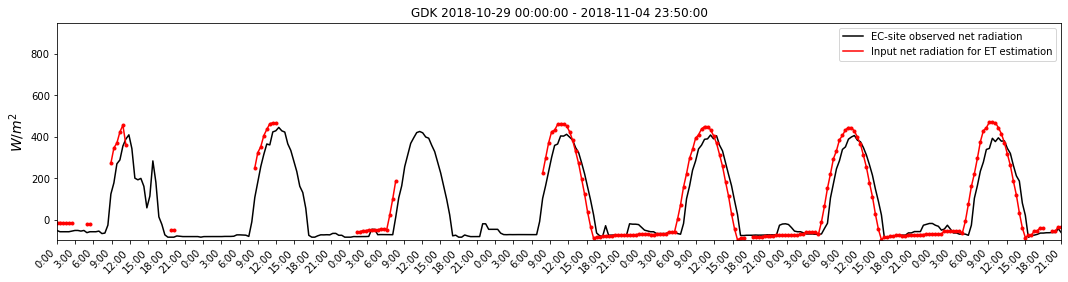

N: 6715
R²: 0.9024160789308766
RMSE: 77.70185621594673
Bias: -9.345515178307081e-15
MAE 50.676434779466554


<Figure size 432x288 with 0 Axes>

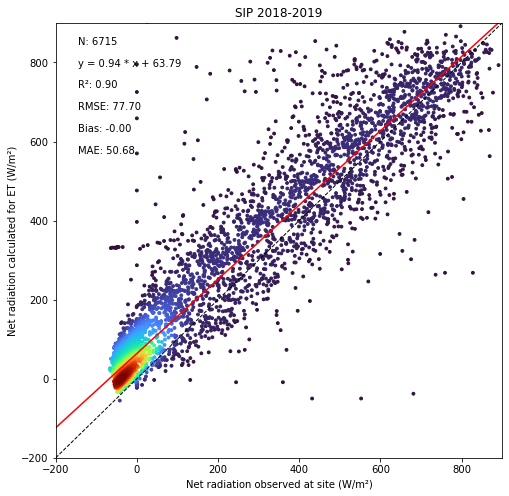

<Figure size 432x288 with 0 Axes>

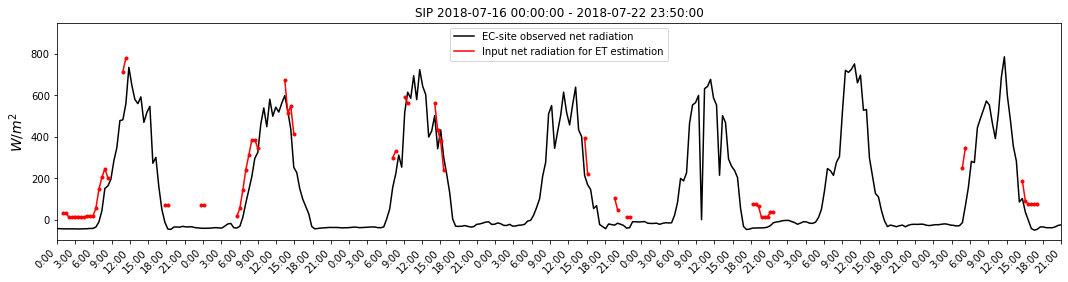

<Figure size 432x288 with 0 Axes>

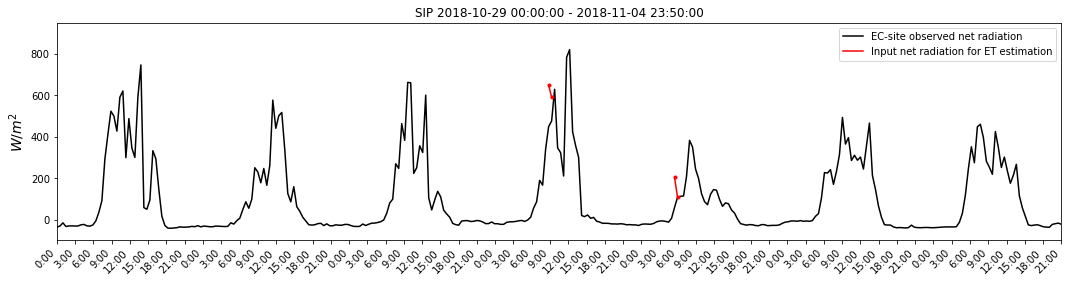

N: 8604
R²: 0.8258558300913446
RMSE: 113.9490019234955
Bias: 1.0200632115421615e-14
MAE 82.88774010628251


<Figure size 432x288 with 0 Axes>

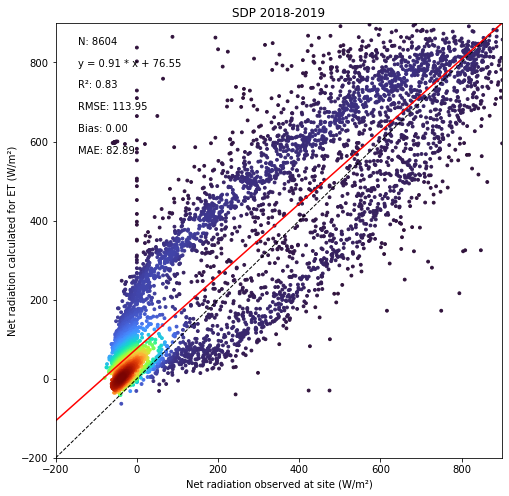

<Figure size 432x288 with 0 Axes>

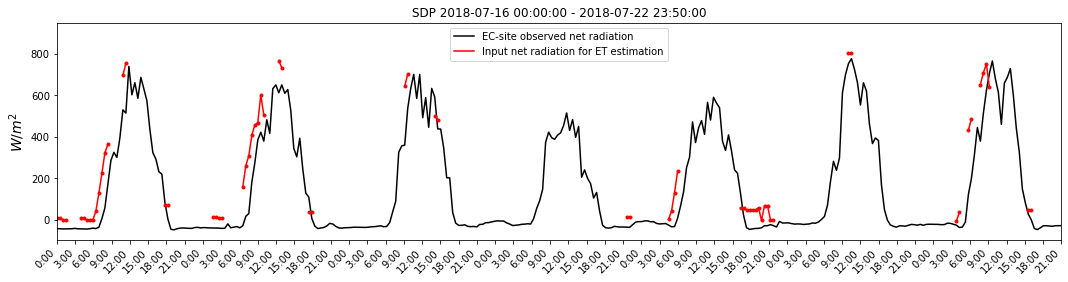

<Figure size 432x288 with 0 Axes>

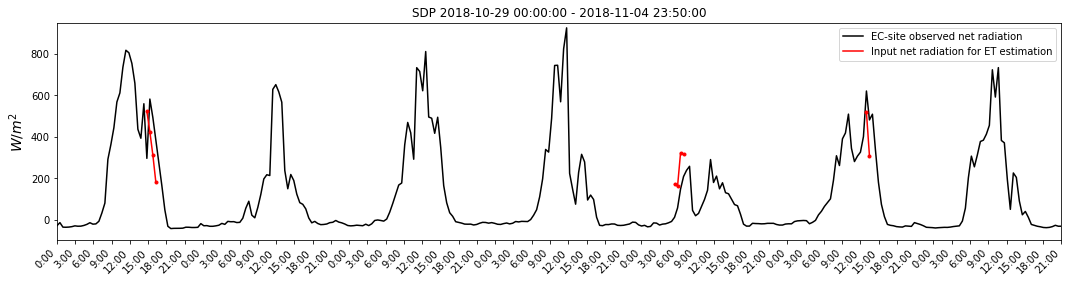

<Figure size 432x288 with 0 Axes>

In [5]:
for site_name in site_names:
    SITE_CAL_CSV = os.path.join(DATA_FOLDER, site_name+'_Rnet.csv')
    cal_timelist, site_cal = read_site_csv(SITE_CAL_CSV)

    SITE_OBS_CSV = os.path.join(SITE_FOLDER, 'Rnet', site_name+'_2018_2019_Rn.csv')
    site_obs = read_site_csv_30minto10min(SITE_OBS_CSV)

    mapping_comparison_single(site_obs, site_cal, site_name+' 2018-2019')
    show_r_net_curve_week(site_name, cal_timelist, 28, site_obs, site_cal, 0)
    show_r_net_curve_week(site_name, cal_timelist, 43, site_obs, site_cal, 0)